# 03. Logistic Regression Classification
***

In this chapter we will use a first learning algorithm which is Logistic Regression. We are not going to recall all the math and logic behind this learning method. We are going to apply it to the training model in order to find the best predictive model, then test our model with the test dataset.

In [504]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from matplotlib import rcParams

***
## Loading the data

In [505]:
data = pd.read_csv('./data/train_clean.csv')
data.head()

,Survived,SibSp,Parch,Fare,Gender,Boarding_C,Boarding_Q,Boarding_S,Age,Pclass_1,Pclass_2,Pclass_3
0,0,1,0,7.2500,1,0,0,1,22.0,0,0,1
1,1,1,0,71.2833,0,1,0,0,38.0,1,0,0
2,1,0,0,7.9250,0,0,0,1,26.0,0,0,1
3,1,1,0,53.1000,0,0,0,1,35.0,1,0,0
4,0,0,0,8.0500,1,0,0,1,35.0,0,0,1


In [506]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 12 columns):
Survived      889 non-null int64
SibSp         889 non-null int64
Parch         889 non-null int64
Fare          889 non-null float64
Gender        889 non-null int64
Boarding_C    889 non-null int64
Boarding_Q    889 non-null int64
Boarding_S    889 non-null int64
Age           889 non-null float64
Pclass_1      889 non-null int64
Pclass_2      889 non-null int64
Pclass_3      889 non-null int64
dtypes: float64(2), int64(10)
memory usage: 83.4 KB


***
## Logistic Regression on the Whole Dataset

In this first use of Logistic Regression using `sklearn`, we are going to use the full dataset to build the model.

In [507]:
# Building X and Y from the whole dataset
X = data.drop(['Survived'], axis = 1)
Y = data['Survived']

In [508]:
# Building the model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [509]:
# Making predictions
Y_hat = model.predict(X)

In [510]:
print Y_hat[:20] # First 10 predictions...
print Y[:20].values # ... compared to real outputs

[0 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 1]
[0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1]


Which seems good. Now the score of the model:

In [511]:
model.score(X, Y)

0.813273340832396

### Improve the model removing attributes

In [512]:
X2 = X.drop('Boarding_S', axis = 1)

model2 = LogisticRegression()
model2.fit(X2, Y)
model2.score(X2, Y)

0.81214848143981999

Droping the `Boarding_S` attribute increased the model score compared to using all the attributes.

***
## Logistic Regression on the Training dataset

Here, we are going to split the dataset into two groups: training and testing datasets. We will use `train_test_split`:

In [513]:
from sklearn.cross_validation import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8)

print X_train.shape
print Y_train.shape
print X_test.shape
print Y_test.shape

(711, 11)
(711,)
(178, 11)
(178,)


In [514]:
model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [515]:
print model.score(X_train, Y_train)
print model.score(X_test, Y_test)

0.814345991561
0.786516853933


Here, the learning model from the training dataset has a good score but performs badly on the testing dataset. This difference in scoring will fluctuate depending on the dataset splits. A more robust methodology is to perform a k-fold cross-validation on the whole dataset.

***
## Evaluating Logistic Regression Model using k-fold Cross Validation

In [516]:
from sklearn.cross_validation import KFold

In [533]:
train_scores, test_scores = [], []
folds_list = np.arange(2, 31)

for n_folds in folds_list:

    current_train_scores, current_test_scores = [], []

    for train_indexes, test_indexes in KFold(n = X.shape[0], n_folds = n_folds):
        X_train, Y_train = X.values[train_indexes], Y.values[train_indexes]
        X_test, Y_test = X.values[test_indexes], Y.values[test_indexes]

        model = LogisticRegression()
        model.fit(X_train, Y_train)
        
        current_train_scores.append(model.score(X_train, Y_train))
        current_test_scores.append(model.score(X_test, Y_test))
    
    train_scores.append(np.mean(current_train_scores))
    test_scores.append(np.mean(current_test_scores))

In [534]:
# The k that maximizes the average testing score with the corresponding score
print "k = %d has a score of %f" % (folds_list[np.argmax(test_scores)], np.max(test_scores))

k = 14 has a score of 0.808780


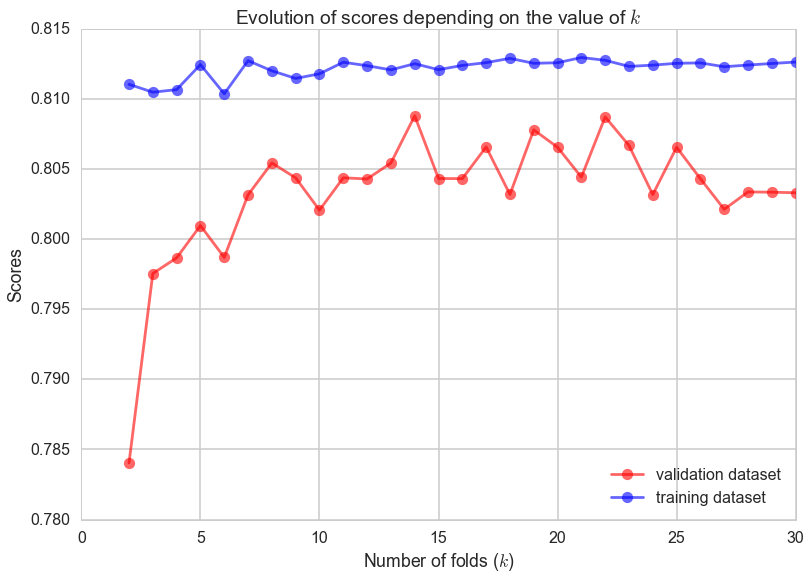

In [535]:
plt.plot(folds_list, test_scores, 'r-o', alpha = 0.6, label = 'validation dataset')
plt.plot(folds_list, train_scores, 'b-o', alpha = 0.6, label = 'training dataset')
plt.xlabel('Number of folds ($k$)')
plt.ylabel('Scores')
plt.legend(loc = 'lower right')
plt.title('Evolution of scores depending on the value of $k$')

Using k-folds cross-validation degraded the scoring on the training dataset, but improved the testing dataset.

***
## Building k Logistic Regression models

The idea is to create _k_ different models (based on different datasets) and perform a voting on the final prediction. Here _k_ is unknown and should be kept to maximize good predictions. We are going to split the data into a test dataset, and a cross-validation dataset to find the ultimate _k_ and the k-models.

To do so, let's build a class that have the same syntaxe of any `sklearn` methods.

In [520]:
# The k Logistic Regression models algorithm
class KLR(object):
    
    def __init__(self, min_k = 2, max_k = 30):
        self.min_k = min_k
        self.max_k = max_k
        self.optimum_k = 0
        self.models = []
        self.train_score = 0
    
    def fit(self, X, Y):
        for k in np.arange(self.min_k, (self.max_k + 1)):
            current_scores = []
            current_models = []
            
            for train_indexes, test_indexes in KFold(len(X), n_folds = k):
                model = LogisticRegression()
                model.fit(X[train_indexes], Y[train_indexes])
                current_scores.append( model.score(X[test_indexes], Y[test_indexes]) )
                current_models.append( model )
                
            if np.mean(current_scores) > self.train_score:
                self.train_score = np.mean(current_scores)
                self.models = current_models
                self.optimum_k = k
    
    def predict(self, X):
        predictions = [model.predict(X) for model in self.models]
        
        sum_predictions = predictions[0]
        for i in np.arange(1, len(predictions)):
            sum_predictions = sum_predictions + predictions[i]

        return (sum_predictions >= (self.optimum_k / 2.)).astype(int)
        # This is similar as doing the mean and then approximating by 0 or 1
    
    def score(self, X, Y):
        return np.mean([model.score(X, Y) for model in self.models])

In [521]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.7)

In [522]:
klr = KLR()

In [523]:
klr.fit(X_train.values, Y_train.values)

In [524]:
# How many different Logistic Regressions got the best mean score on validation test
klr.optimum_k

19

In [525]:
klr.train_score

0.81180223285486441

In [526]:
# First 20 predictions vs real values (0: died, 1: survived)
print klr.predict(X_test.values)[:20]
print Y_test.values[:20]

[0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
[1 1 0 0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0]


In [527]:
klr.score(X_test.values, Y_test.values)

0.81214271634141533

If you run several times the previous scripts, you will see that the final score fluctuates a lot depending on how the data in split between training dataset and testing dataset. The following script will perform the previous scripts many times to have a mean of the learning model score.

In [528]:
scores = []

for i in range(20): # We will run the KLR n-times to have an average score of the methodology
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.7)
    
    klr = KLR()
    klr.fit(X_train.values, Y_train.values)
    scores.append(klr.score(X_test.values, Y_test.values))

print "Average methodology score: %f" % np.mean(scores)

Average methodology score: 0.810255


***
## Conclusion

In this chapter, we tried to predict the passengers survival using Logistic Regression learning model.

We performed quite good approximations with this methodology especially using cross validation. We also tried a more complexe variation of LR by building many LR models and averaging results, but this increase in complexity didn't lead to better predictions.

In the next chapters, we will try more complex learning algorithms. But as we learned in this chapter, more complex doesn't mean better!